# Development & Discovery Notebook, FixMatchSeg
In this notebook we document the process of working with the platform and zod to create FixMatchSeg. This notebook is not intended to be run as a script, but rather to be used as a reference for how to use the platform and zod.

## Initialise the platform and zod

In [1]:
from fedswarm import Platform

# basic config without any learning
config = {
    "data":{
        "path": "/mnt/ZOD",
        "version": "full",
        "ratio": 1,
        "img_size": [400, 1420],
        "transforms": "",
        "shuffle_seed": 101,
        "decentralised_shuffle_seed": 101,
        "dataloader_args": {
            "batch_size": 8,
            "num_workers": 20,
            "prefetch_factor": 4,
            "batch_size": 8,
            "shuffle": True,
        },
        "train_val_id_generator":"ego_road",
        "dataset_getitem":"ego_road_segmentation",
    },
    "model":{
        "name": "fixmatchseg",
        "args": {},
        "loss": "L1Loss",
        "optimiser": "Adam",
        "optimiser_args": {
            "lr": 0.0001,
        }
    }
}

platform = Platform(config, data_only=True, write=False)

FixMatchSeg is not well supported, please use it with caution as config validation may not work


No same run found, creating new run


Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [2]:
print("train", len(platform.data.train.dataset))
print("val", len(platform.data.val.dataset))

train 52199
val 2882


In [3]:
# plotting settings
import matplotlib.pyplot as plt
import scienceplots
from tbparse import SummaryReader

plt.style.use('science')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams.update({'font.size': 8})

Get some relevant training ids and the `zod_frames` object

In [4]:
# some global variables that we will use later
train_ids = platform.data.train._ids
zod_frames = platform.data.zod_frames

## Visualise the data

We will visualise the data using some ZOD features.

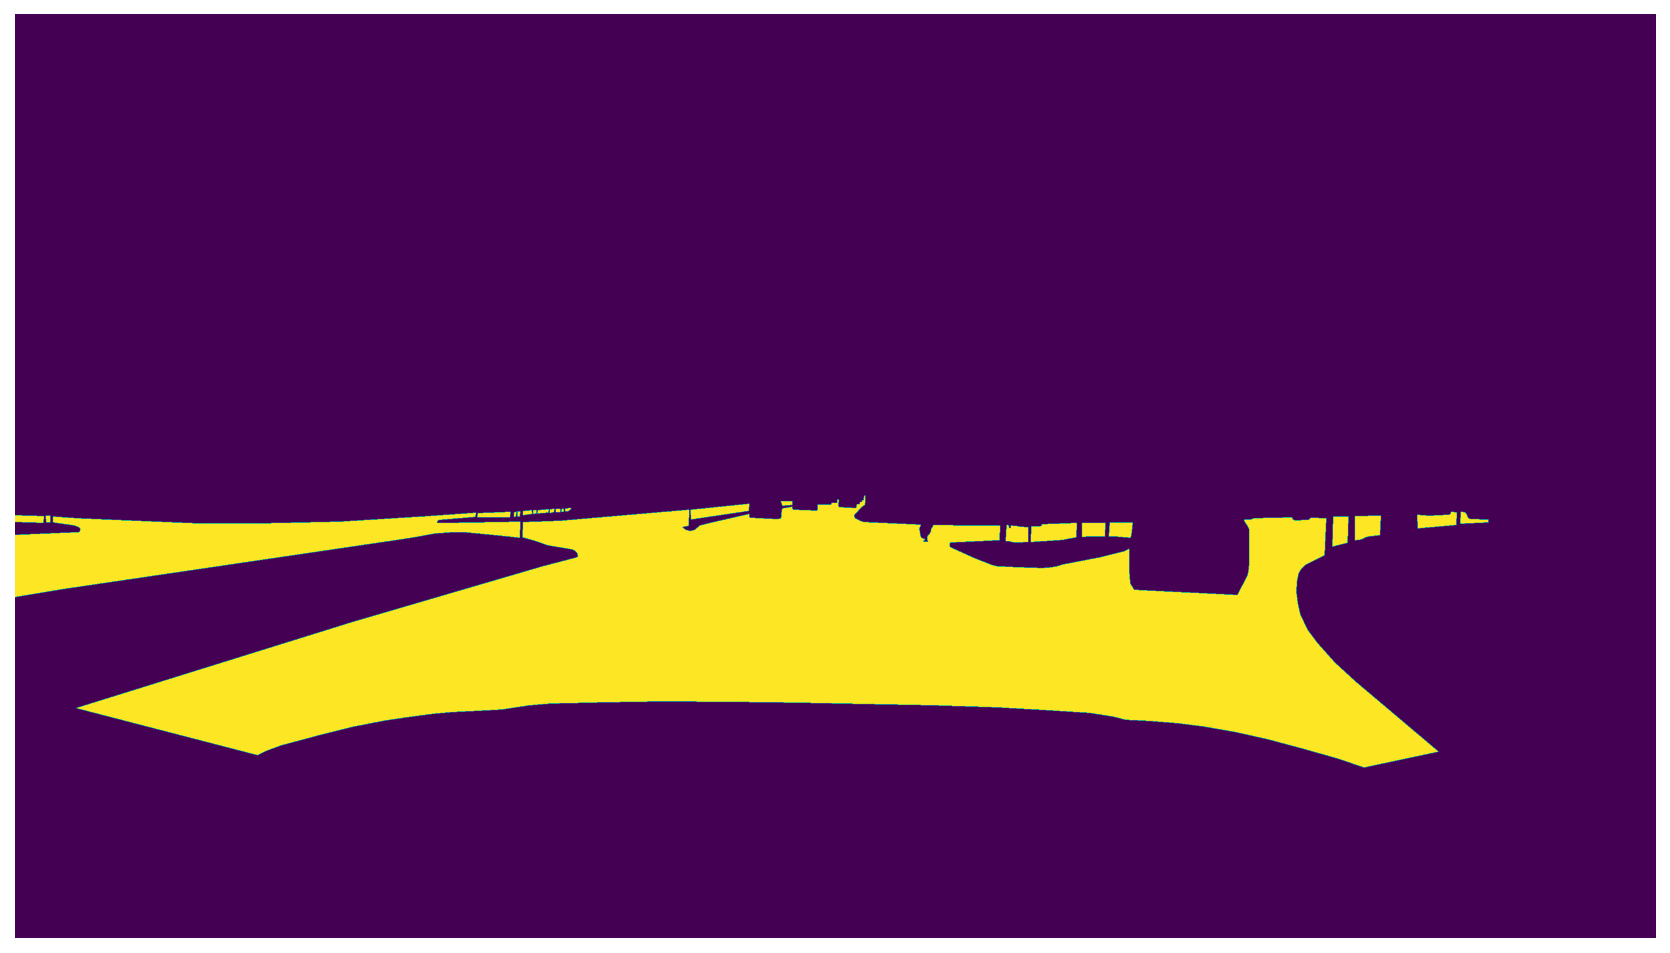

In [67]:
# fetch 
image, annotation = platform.data.train.dataset[99]
image = image.numpy()

mask = annotation.numpy()

import matplotlib.pyplot as plt
# visualize the mask
plt.axis("off")
plt.imshow(mask.squeeze())
plt.show()

Overlaying the mask on the image

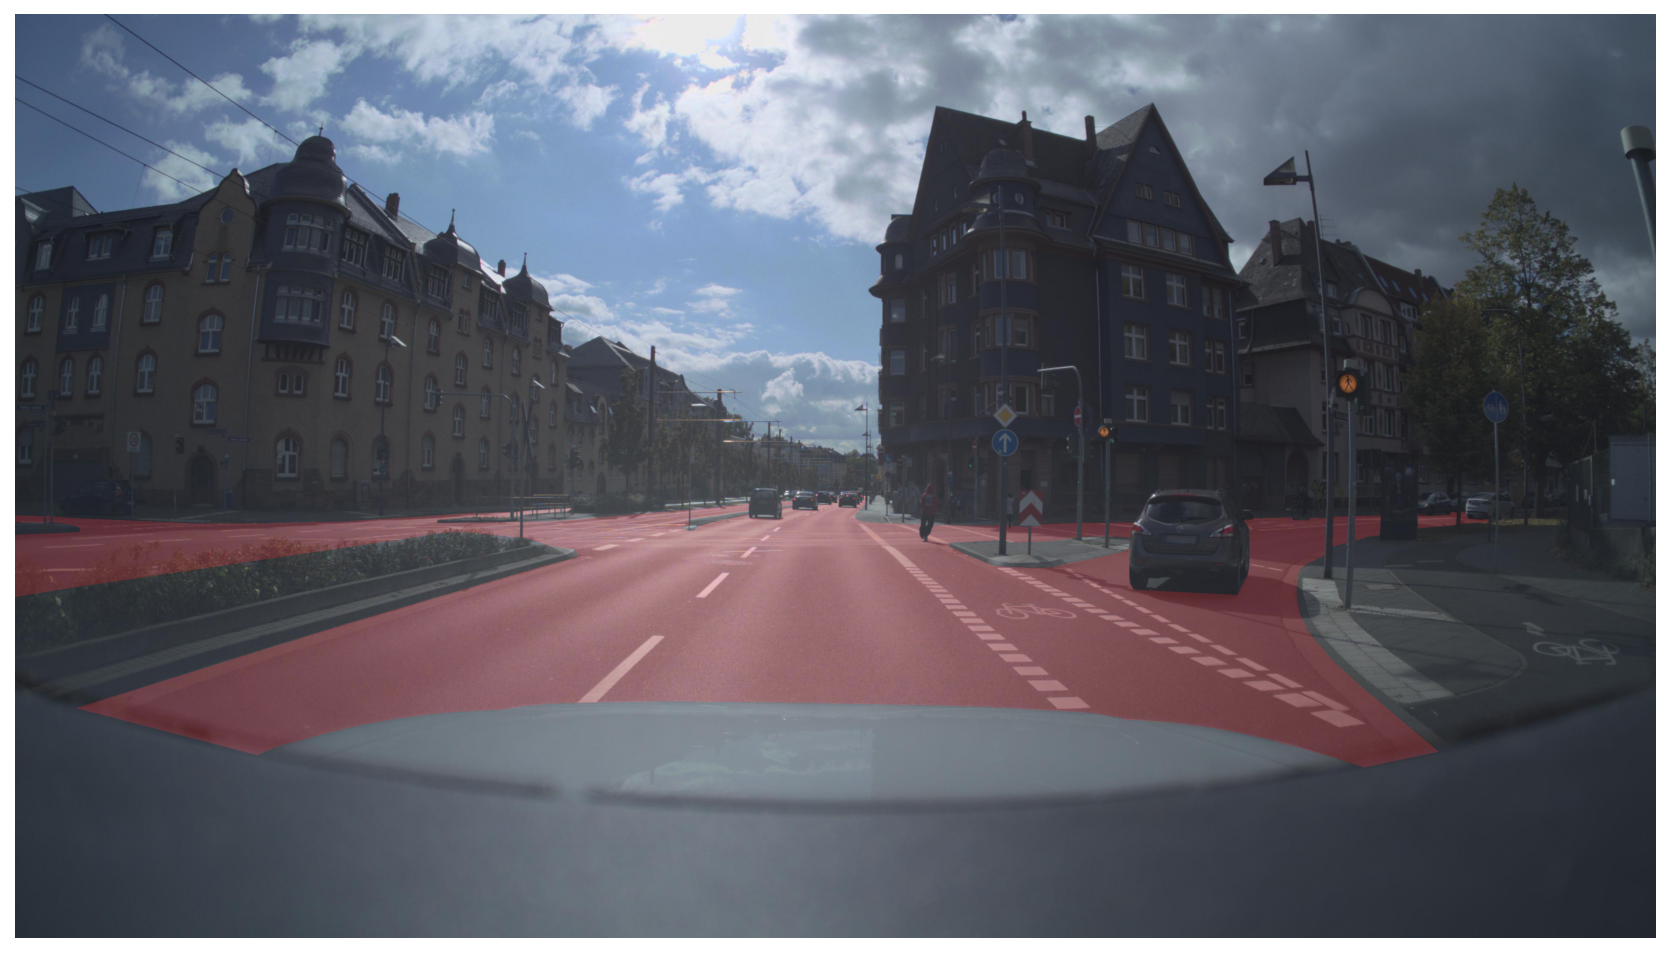

In [68]:
from zod.visualization.polygon_utils import overlay_mask_on_image

# overlay the mask on the image
to_plottable = lambda image: ((image - image.min()) / (image.max() - image.min()) * 255).astype("uint8").transpose(1, 2, 0)

rendered_image = overlay_mask_on_image(mask, to_plottable(image), fill_color=(100, 0, 0), alpha=0.5)

# visualize the mask
plt.axis("off")
plt.imshow(rendered_image)
plt.show()

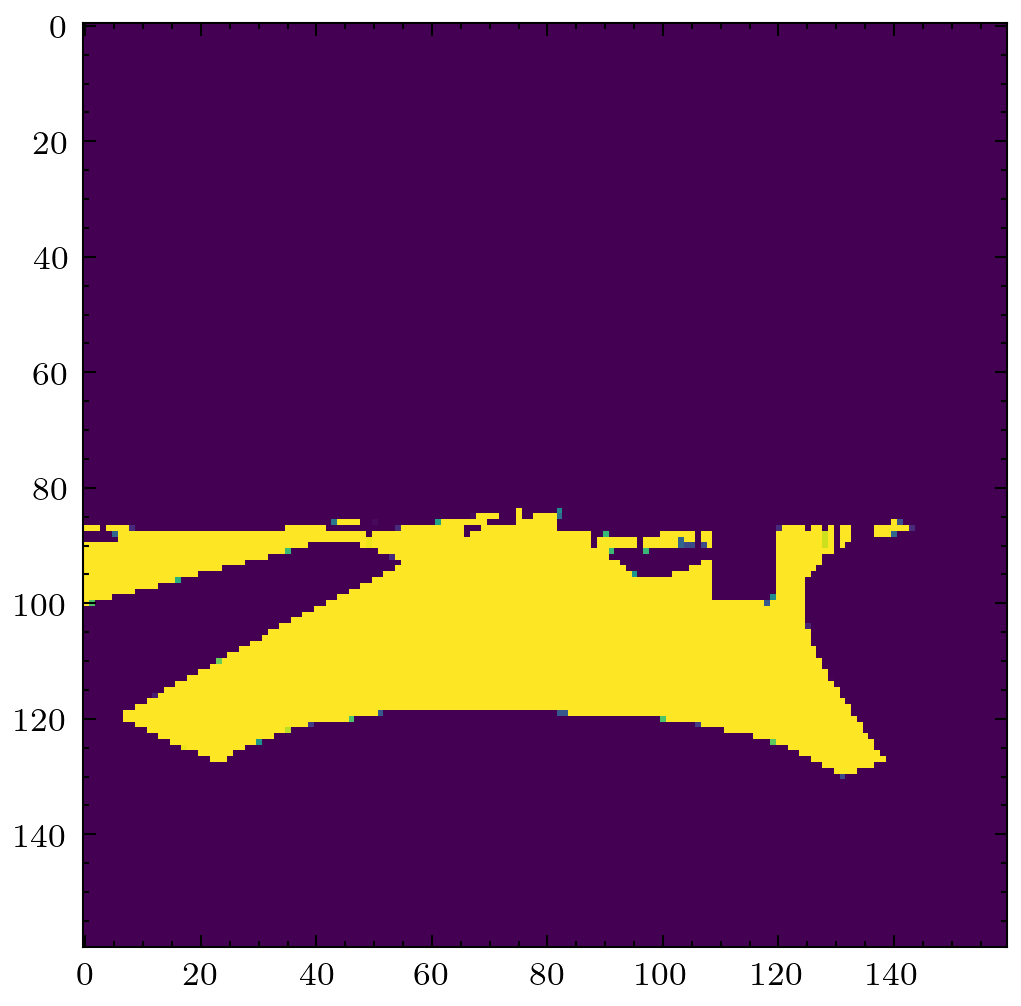

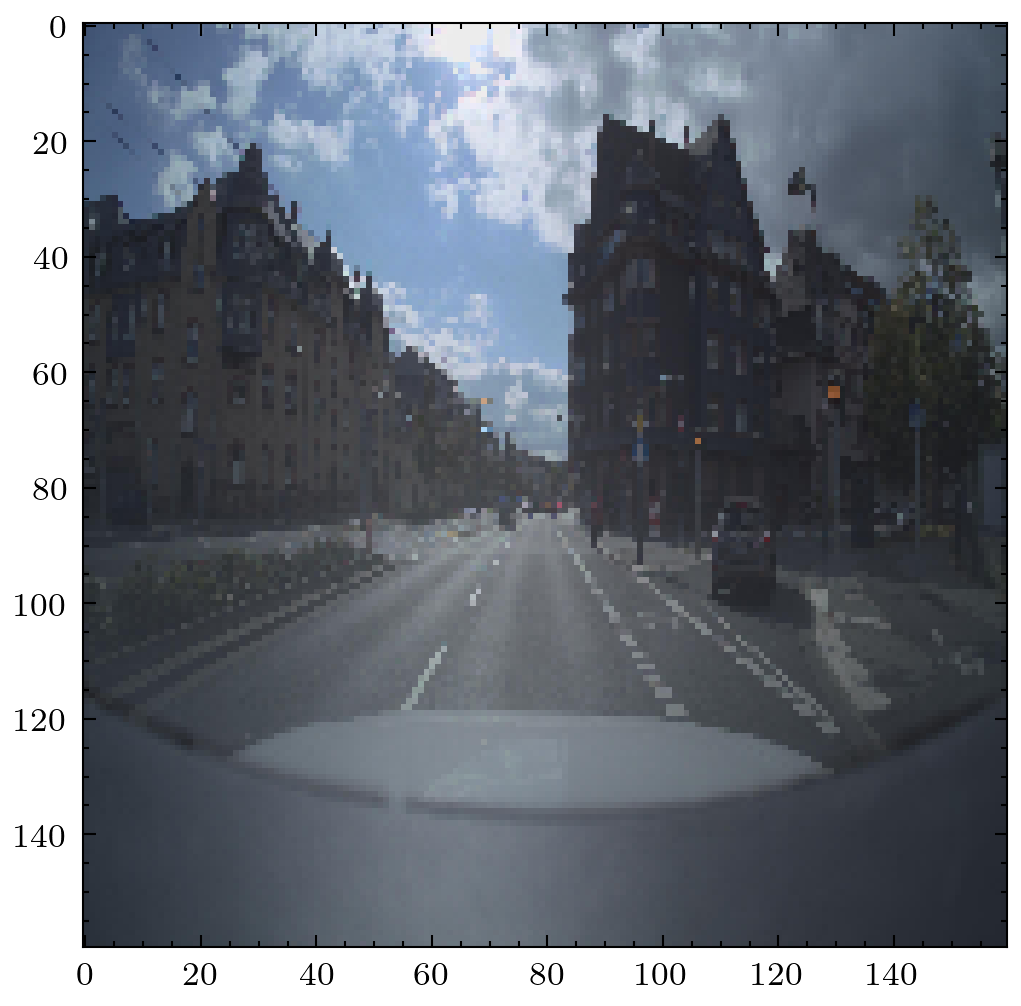

In [82]:
from torchvision.transforms import *
downSample = Compose([ToTensor(), Resize((160, 160))])
downSampled_image = downSample(image.transpose(1, 2, 0))
downSampled_mask = downSample(mask)

plt.imshow(downSampled_mask.squeeze())
plt.show()  
plt.imshow(downSampled_image.numpy().transpose(1, 2, 0))
plt.show()

## Reconstructing the training loop

__Loss__ <br>
Excerpt from the paper:
> For semantic segmentation loss, we used the widely used soft dice loss DL defined on [27] combined with boundary loss BL explained in [28]. In this study, both dice loss and boundary loss have equal contributions in the final loss calculation.

__Architecture diagram__

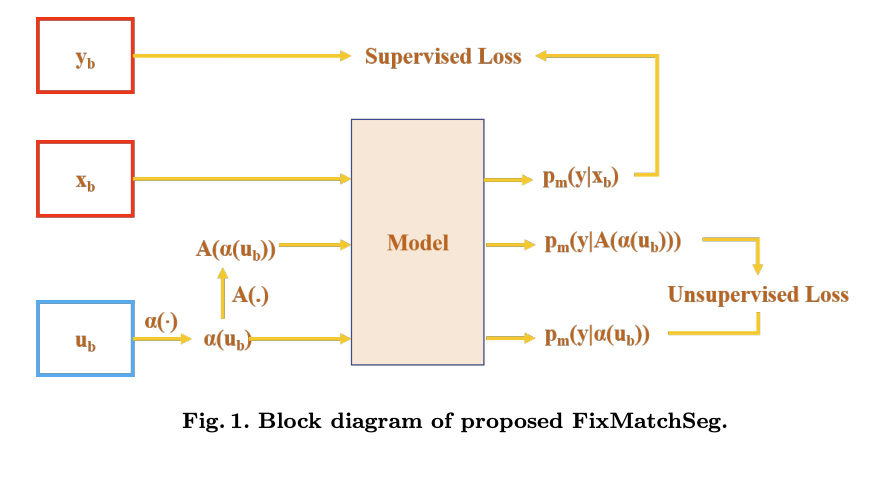

# Construct dataset

In [2]:
import zod
zod_frames = zod.ZodFrames("/mnt/ZOD", "full")

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [6]:
train_ids = list(zod_frames._train_frames.keys())
val_ids = list(zod_frames._val_frames.keys())

In [8]:
from zod.constants import AnnotationProject
ego_road_id_set = dict()
for id_set, name in zip([train_ids, val_ids], ["train", "val"]):
    ego_road_id_set[name] = set()
    with_ego_road = ego_road_id_set[name]
    for id in id_set:
        if len(zod_frames[id].info.annotation_frames.get(AnnotationProject.EGO_ROAD)) > 0:
            with_ego_road.add(id)
    ego_road_id_set[name] = list(ego_road_id_set[name])

In [39]:
import segmentation_models_pytorch as smp
from zod.utils.polygon_transformations import polygons_to_binary_mask
import numpy as np
import torch 

# test the core test
label = zod_frames[ego_road_id_set["train"][0]].get_annotation(AnnotationProject.EGO_ROAD)
mask = polygons_to_binary_mask(label)
mask = mask.astype("float32")
mask_tensor = torch.from_numpy(mask).unsqueeze(0)

loss = smp.losses.DiceLoss(mode="binary", from_logits=False)
loss(mask_tensor, mask_tensor)

In [ ]:
import ray
from tqdm import tqdm

# Initialize Ray
ray.init(num_cpus=20)

@ray.remote
def process_id(id, zod_frames, loss):
    try:
        label = zod_frames[id].get_annotation(AnnotationProject.EGO_ROAD)
        mask = polygons_to_binary_mask(label)
        mask = mask.astype("float32")
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        loss(mask_tensor, mask_tensor)
        return (id, True)
    except Exception as e:
        return (id, False)

# Put large objects in the object store
zod_frames_ref = ray.put(zod_frames)
# define loss
loss = smp.losses.DiceLoss(mode="binary", from_logits=False)

ego_road_id_set_valid = dict()
ego_road_id_set_faulty = dict()

for set_name, ids in ego_road_id_set.items():
    ego_road_id_set_valid[set_name] = set()
    ego_road_id_set_faulty[set_name] = set()

    results = ray.get([process_id.remote(id, zod_frames_ref, loss) for id in ids])

    for result in results:
        id, is_valid = result
        if is_valid:
            ego_road_id_set_valid[set_name].add(id)
        else:
            ego_road_id_set_faulty[set_name].add(id)

    ego_road_id_set_valid[set_name] = list(ego_road_id_set_valid[set_name])
    ego_road_id_set_faulty[set_name] = list(ego_road_id_set_faulty[set_name])

# Shutdown Ray
ray.shutdown()

In [65]:
from tqdm.notebook import tqdm

# do it for all
ego_road_id_set_valid = dict()
ego_road_id_set_faulty = dict()

for set_name, ids in tqdm(ego_road_id_set.items(), desc="Processing sets"):
    ego_road_id_set_valid[set_name] = set()
    ego_road_id_set_faulty[set_name] = set()
    for id in tqdm(ids, desc="Processing IDs in set"):
        try:
            label = zod_frames[id].get_annotation(AnnotationProject.EGO_ROAD)
            mask = polygons_to_binary_mask(label)
            mask = mask.astype("float32")
            mask_tensor = torch.from_numpy(mask).unsqueeze(0)
            loss(mask_tensor, mask_tensor)
            ego_road_id_set_valid[set_name].add(id)
        except Exception as e:
            ego_road_id_set_faulty[set_name].add(id)
            continue
    ego_road_id_set_valid[set_name] = list(ego_road_id_set_valid[set_name])
    ego_road_id_set_faulty[set_name] = list(ego_road_id_set_faulty[set_name])


Processing sets:   0%|          | 0/2 [00:00<?, ?it/s]

Processing IDs in set:   0%|          | 0/53287 [00:00<?, ?it/s]

Processing IDs in set:   0%|          | 0/5890 [00:00<?, ?it/s]

In [74]:
assert set(ego_road_id_set_valid["train"]).intersection(set(ego_road_id_set_valid["val"])) == set()
print("Number of valid train IDs: ", len(ego_road_id_set_valid["train"]), "Out of total: ", len(ego_road_id_set["train"]))
print("Number of valid val IDs: ", len(ego_road_id_set_valid["val"]), "Out of total: ", len(ego_road_id_set["val"]))

Number of valid train IDs:  52199 Out of total:  53287
Number of valid val IDs:  5763 Out of total:  5890


In [66]:
# save dict to file
import json

with open("ego_road_id_set_valid.json", "w") as f:
    json.dump(ego_road_id_set_valid, f)
with open("ego_road_id_set_faulty.json", "w") as f:
    json.dump(ego_road_id_set_faulty, f)

We have already defined what the model is like in a custom model file. So we can import it using the platform

In [ ]:
from fedswarm.utils.models.model_manager import load_model_from_name

# load the FixMatchSeg model
model = load_model_from_name(config["model"]["name"], **config["model"]["args"]).cuda()

We should note that:
> Unlike classification tasks, in semantic segmentation,
the output target is not invariant under geometric transformations such as flips,
affine or elastic distortions that change the shape or location of objects in the image.

In [ ]:
from torchinfo import summary
from fedswarm.utils.models.model_manager import load_model_from_name


In [ ]:
# load the FixMatchSeg model
model = load_model_from_name("resnet18-melted", num_output=51)
summary(model, (8, 3, 256, 256))

In [ ]:
model = load_model_from_name("mobilenet", num_output=51)
summary(model, (8, 3, 256, 256))

In [2]:
from fedswarm import Platform

# basic config without any learning
config = {
    "data":{
        "path": "/mnt/ZOD",
        "version": "full",
        "ratio": 0.0977035,
        "ratio_val": 0.43385,
        "img_size": [160,160],
        "split_train": 0.01961,
        "skip_test": True,
        "transforms": "[Resize(img_size)]",
        "weak_augmentation": "[RandomHorizontalFlip(p=1), RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))]",
        "strong_augmentation": "[GaussianBlur(13, sigma=(0.01, 2.0)), RandomAdjustSharpness(10, p=.5), RandomSolarize(.5, p=.5), ColorJitter(.2,.7,.4,.5), RandomInvert(p=0.5)]",
        "normalisation": "[Normalize(mean=[0.337, 0.345, 0.367], std=[0.160, 0.180, 0.214])]",
        "shuffle_seed": 150,
        "decentralised_shuffle_seed": 150,
        "dataloader_args": {
            "batch_size": [2, 16],
            "num_workers": 12,
            "prefetch_factor": 128,
            "shuffle": True,
        },
        "train_val_id_generator":"ego_road",
        "dataset_getitem":"ego_road_segmentation",
    },
    "model":{
        "name": "fixmatchseg",
        "args": {},
        "loss": "",
        "optimiser": "Adam",
        "optimiser_args": {
            "lr": 1e-3,
        },
        "tau": 0.99
    },
    "central": {
        "train": False,
        "use_gpu": True,
        "epochs": 30
    }
}

platform = Platform(config, data_only=True, write=False)

FixMatchSeg is not well supported, please use it with caution as config validation may not work


No same run found, creating new run


Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [3]:
labelled = platform.data.central.train.labelled.dataloader
unlabelled = platform.data.central.train.unlabelled.dataloader

Dataloader not created explicitly, creating it, do not forget to unmount it!
Dataloader not created explicitly, creating it, do not forget to unmount it!


In [11]:
labelled_images, image_labels = next(iter(labelled))
unlabelled_images, _ = next(iter(unlabelled))

In [5]:
# plotting settings
import matplotlib.pyplot as plt
import scienceplots
from tbparse import SummaryReader

plt.style.use('science')
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams.update({'font.size': 8})

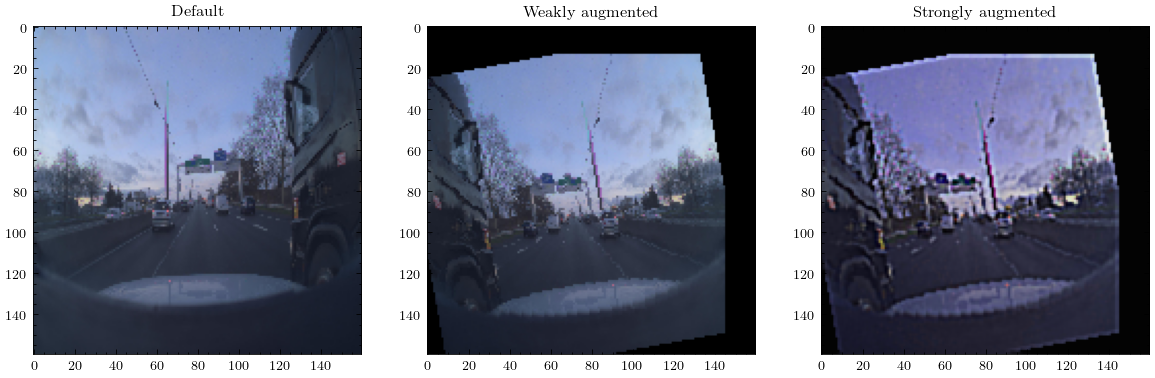

In [13]:
# transform the images augment flip
from torchvision.transforms import *
# For weak augmentation α, we chose random rotation and elastic distortions
weak_augmentation = Compose([RandomHorizontalFlip(p=1), RandomRotation(degrees=10), RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))])
# For strong augmentation A, we modified the sharpness and contrast of the weakly augmented images and
# added Gaussian blur. In order to have the same output target from the weakly
# augmented and strongly augmented images, instead of applying strong augmentation directly to the unlabeled image, 
# we applied it to the weakly augmented version of that image. For the strong augmentation, we did not apply any kind
# of geometric or shape-changing transformation, which thus maintains the same
# geometrical shape of the objects in both weakly and strongly augmented images.
strong_augmentation = Compose([GaussianBlur(13, sigma=(0.01, 2.0)), RandomAdjustSharpness(10, p=.5), RandomSolarize(.5, p=.5), ColorJitter(.2,.7,.4,.5), RandomInvert(p=0.5)])
normalisation = Compose([Normalize(mean=[0.337, 0.345, 0.367], std=[0.160, 0.180, 0.214])])

default_img = labelled_images[1].cpu()
weak_img = weak_augmentation(default_img)
strong_img = strong_augmentation(weak_img)
plt.subplot(1, 3, 1)
plt.title("Default")
plt.imshow(default_img.permute(1, 2, 0))
plt.subplot(1, 3, 2)
plt.title("Weakly augmented")
plt.imshow(weak_img.permute(1, 2, 0))
plt.subplot(1, 3, 3)
plt.title("Strongly augmented")
plt.imshow(strong_img.permute(1, 2, 0))
plt.savefig("augmentation.pdf", bbox_inches='tight')
plt.show()

In [ ]:
import torch
from fedswarm.utils.models.model_manager import load_model_from_name
import segmentation_models_pytorch as smp
from torch.functional import F
model = load_model_from_name("fixmatchseg")
model.cuda()
device = next(model.parameters()).device

network= model

# perform augmentation on cpu
unlabelled_weakly_augmented_images = weak_augmentation(unlabelled_images)
unlabelled_strongly_augmented_images = strong_augmentation(unlabelled_weakly_augmented_images)
# normalise the images on cpu
normalised_labelled_images = normalisation(labelled_images)
normalised_unlabelled_weakly_augmented_images = normalisation(unlabelled_weakly_augmented_images)
normalised_unlabelled_strongly_augmented_images = normalisation(unlabelled_strongly_augmented_images)
# move images to gpu
input = torch.concat([normalised_labelled_images, normalised_unlabelled_weakly_augmented_images, normalised_unlabelled_strongly_augmented_images], dim=0)
input = input.to(device)
# move labels to gpu
image_labels = image_labels.to(device)
# send the images through the network
output = network(input)
# split the output into the three parts
shapes = [labelled_images.shape[0], unlabelled_weakly_augmented_images.shape[0], unlabelled_strongly_augmented_images.shape[0]]
labelled_predictions, unlabelled_weakly_augmented_predictions, unlabelled_strongly_augmented_predictions = torch.split(output, shapes, dim=0)


# We do this because the predictions are sigmoided
qb = torch.abs(unlabelled_weakly_augmented_predictions - 0.5) * 2
max_labelled_confidences = torch.abs(labelled_predictions -0.5) * 2
mean_labelled_confidence = torch.mean(max_labelled_confidences)
# get binary labels
qhatb = (unlabelled_weakly_augmented_predictions > 0.5).float()
# calculate the mean of the max values
qb_bar = torch.mean(qb, dim=[1, 2, 3])
# define tau
tau = 0.90

# get indicies of psuedo labels
psuedo_indicies = torch.nonzero(qb_bar > tau)
psuedo_labels = qhatb[psuedo_indicies]
selected_unlabelled_strongly_augmented_predictions = (
    unlabelled_strongly_augmented_predictions[psuedo_indicies]
)


# calculate the loss
supervised_loss = smp.losses.DiceLoss(mode="binary")(labelled_predictions, image_labels)
if len(psuedo_indicies) > 0:
    unsupervised_loss = smp.losses.DiceLoss(mode="binary")(selected_unlabelled_strongly_augmented_predictions, psuedo_labels)
else:
    unsupervised_loss = 0